## GAAIMS 
### EDSS prediction analysis on the reduced 2 NMF regress-N features for revision of paper: We do binary classification with groups Mild vs Moderate with EDSS 1-4.5 vs 5-6 respectively. 
#### Rachneet Kaur 


In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn import decomposition

import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupKFold
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\purpl\\Box\\GAIT\\sample_data\\data_export\\'

In [3]:
#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\csv files\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L', 'index']
regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = regressN_df[regressN_df['Label']==1] #Keeping only PwMS

#Reading the EDSS scores for PwMS 
edss= pd.read_csv('..//edss.csv')
#Keeping edss of only the 17 PwMS subjects we have the raw data for 
edss = edss[edss['PID'].isin(regressN_df[regressN_df['Label']==1]['PID'].unique())].reset_index().drop('index', axis =1)

#Attaching the EDSS to the dataframe
regressN_df['edss'] = regressN_df['PID'].map(edss.set_index('PID')['EDSS'])

#Creating the new labels for mild (EDSS 1-4.5) vs moderate (EDSS 5-6)
regressN_df['Label'][regressN_df['edss']<=4.5] = 0 #0 for mild 
regressN_df['Label'][regressN_df['edss']>=5] = 1 #1 for moderate

Regress-N data shape:  (3230, 25)


In [4]:
features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'cadence', 'stride_length', 'stride_width',
       'LeftFPA', 'RightFPA', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL','Butterfly_x_abs', 'ButterflySQ_x']

In [5]:
regressN_df

,stride_time,swing_time,stance_time,SS_R,DS_L,DS_R,stride_length,stride_width,cadence,stride_speed,...,force_TOL,force_MidSSL,LeftFPA,RightFPA,Butterfly_x_abs,ButterflySQ_x,PID,TrialID,Label,edss
905,1.427284,0.825449,1.698498,1.451010,2.275607,1.591079,0.356788,1.603865,0.693365,0.247979,...,1.023453,1.144372,-17.906300,-81.365486,0.093181,0.553099,300,1,1,6.0
906,1.364776,0.929937,1.555251,1.173380,2.117304,1.722825,0.366358,1.933280,0.725122,0.266292,...,0.947790,1.111496,16.643585,-71.453487,0.987034,1.937089,300,1,1,6.0
907,1.548829,1.097116,1.744542,1.058137,2.127198,2.685580,0.459438,1.783671,0.638953,0.294265,...,0.993012,1.153409,-39.773788,307.247234,5.521313,11.069417,300,1,1,6.0
908,1.310949,0.867244,1.506650,0.948133,2.067834,2.016719,0.417583,1.776315,0.754895,0.315989,...,1.006676,1.128446,25.850804,-221.182818,4.942584,8.453359,300,1,1,6.0
909,1.343939,0.867244,1.555251,0.916703,1.771016,2.574103,0.446703,1.793104,0.736364,0.329727,...,0.970183,1.128360,-8.629545,44.172824,5.981351,13.400158,300,1,1,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,0.874860,0.960934,0.808321,0.969086,0.666459,0.669519,1.128300,1.200901,1.130886,1.297014,...,0.996007,0.917539,2.168443,20.954078,1.032380,0.763975,323,2,0,3.0
3226,0.866059,0.923771,0.813437,0.969086,0.706851,0.648918,1.120058,1.132558,1.142379,1.300624,...,1.007720,0.879937,-2.028938,-9.061530,1.067982,0.808281,323,2,0,3.0
3227,0.878381,0.923771,0.831343,0.942894,0.757340,0.721020,0.985845,1.319821,1.126354,1.128716,...,0.985558,0.955371,1.996335,3.882285,4.415241,10.551841,323,2,0,3.0
3228,0.903025,0.955625,0.851807,0.932418,0.828025,0.751921,0.932572,1.450322,1.095615,1.038582,...,0.956524,0.995181,5.303354,-5.496849,4.460976,10.761418,323,2,0,3.0


### Do NMF of trials W and WT together for subject generalization 

In [ ]:
#Selecting the dataset - Only PwMS in trial W
dataset_W_WT = regressN_df_normal[(regressN_df['Label']==1)] #RegressN - Trial W #['Label'==1] for see progression on only MS (second plot)

#Attaching the EDSS to the corresponding subjects 
dataset_W_WT['edss'] = regressN_df['PID'].map(edss.set_index('PID')['EDSS'])
dataset_W_WT['color'] = 'r' #Initially all red
dataset_W['color'][dataset_W[regressN_df['Label']==0].index] = 'g' #Green for controls 
# dataset['color'][(dataset['edss']>=5) & (dataset['edss']<=6)] = 'r' #Blue for 0 to 4 EDSS score
# # dataset['color'][(dataset['edss']>=3.5) & (dataset['edss']<5)] = 'b' #Blue for 0 to 4 EDSS score

prog_data_W_WT = dataset_W.drop(['color', 'edss'], axis =1)

#Linear methods: NMF/PCA/ICA
# NMF
model_NMF_W_WT = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
# model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
NMF_2D_W_WT = model_NMF_W_WT.fit_transform(prog_data_W_WT)
# NMF_3D = model_NMF3.fit_transform(prog_data)


## Task generalization 
#### Now, we need to first normalize between 0 and 1 and then fit and tranform using an NMF to get 2 features which we shuffle and then use the ones with trial W in training and ones with trial WT in testing. Note that we cannot normalize or do NMF on trial W (training set) and trails WT (testing set) separately because, the resultant vectors from train and test NMFs will have different directions (due to unequal variance). Due to this, we’ll end up comparing data registered on different axes. Therefore, the resulting vectors from train and test data should have same axes.
##### Refer https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/
#### Also, we cannot not combine the train (trials W) and test set (trials WT) to obtain NMF components of whole data at once. Because, this would violate the entire assumption of generalization since test data would get 'leaked' into the training set. In other words, the test data set would no longer remain 'unseen'. Eventually, this will hammer down the generalization capability of the model.
### Hence, for task generalization, we derive the normalization parameters on the training set (trials W) and then use the same parameters to normalize the test set (trials WT). Similarly, for NMF, we fit the 2D NMF on training set (trials W) and then tranform using the fitted NMF both the training (trials W) and the test set (i.e. trials WT). This way, neither we fit NMF on both training and test set separately nor do we mix them and then do NMF together.

In [30]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Input: dataframe, type of normalization (z-score or min-max)
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

In [82]:
def evaluate(model, test_features, trueY):
    test_labels = trueY['Label'] #Dropping the PID
    predictions = model.predict(test_features)
    try:
        prediction_prob = model.predict_proba(test_features)[:, 1] #Score of the class with greater label
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features)[:, 1] #For linear SVM 
    #Stride wise metrics 
    acc = accuracy_score(test_labels, predictions)
    p = precision_score(test_labels, predictions)
    r = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    auc = roc_auc_score(test_labels, prediction_prob)
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Correctly slassified strides i.e. 1 if stride is correctly classified and 0 if otherwise
    temp['correct'] = (temp['Label']==temp['pred'])

    #Proportion of correctly classified strides
    proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  
    proportion_strides_correct['True Label'] = regressN_testY.groupby('PID').first() 

    #Label for the person - 0=healthy, 1=MS patient
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
    (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
    (proportion_strides_correct['correct']<0.5) 

    #Probability of class 1 - MS patient for AUC calculation
    proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
    (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 
    
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_p = precision_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_r = recall_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_f1 = f1_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
    return proportion_strides_correct['prob_class1'], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc]

In [92]:
def models(trainX, trainY, testX, testY, model_name = 'random_forest'):
    '''
    training set: trainX, testX
    testing set: testX, testY
    model: model_name
    '''
    trainY1 = trainY['Label'] #Dropping the PID
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'n_estimators': [40,45,50],\
       'max_depth' : [15,20,25,None],\
       'class_weight': [None, 'balanced'],\
       'max_features': ['auto','sqrt','log2', None],\
       'min_samples_leaf':[1,2,0.1,0.05]
        }
        rf_grid = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator = rf_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv = 5)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = AdaBoostClassifier(random_state=0)
        grid = {
        'n_estimators':[50, 75, 100, 125, 150],\
        'learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0)
        grid = {
        'gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)

    if(model_name == 'gbm'): #GBM
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
        'learning_rate':[0.15,0.1,0.05], \
        'n_estimators':[50, 100, 150],\
        'max_depth':[2,4,7],\
        'min_samples_split':[2,4], \
        'min_samples_leaf':[1,3]
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = xgboost.XGBClassifier(random_state=0)
        grid = {
            'min_child_weight': [1, 5],\
            'gamma': [0.1, 0.5, 1, 1.5, 2],\
            'subsample': [0.6, 0.8, 1.0],\
            'colsample_bytree': [0.6, 0.8, 1.0],\
            'max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'knn'): #KNN
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],\
            'p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = DecisionTreeClassifier(random_state=0)
        grid = {
            'min_samples_split': range(2, 50),\
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = LinearSVC(random_state=0)
        grid = {
            'loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        grid_search = LogisticRegression(random_state=0)
    
    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0)
        grid = {
            'hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    grid_search.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
#     print('best score: ', grid_search.best_score_)
#     print('best_params: ', grid_search.best_params_, grid_search.best_index_)
#     print('Mean cv accuracy on test set:', grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
#     print('Standard deviation on test set:' , grid_search.cv_results_['std_test_score'][grid_search.best_index_])
#     print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
#     print('Standard deviation on train set:', grid_search.cv_results_['std_train_score'][grid_search.best_index_])
#     print('Test set performance:\n')
    stride_person_metrics = evaluate(grid_search, testX, testY)
    return stride_person_metrics

In [93]:
#Trial W for training 
regressN_trial1 = regressN_df[regressN_df['TrialID']==1]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to min-max normalization so that we have all non-negative entries for NMF 
norm_mean, norm_sd = normalize(regressN_trainX, 'm')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd
regressN_testX_norm = (regressN_testX-norm_mean)/norm_sd
#Since for NMF, we must ensure non-negativity of features 
#If after min-max normalization using the training set derived parametrs, some of the test set feature are 
#negative, we just drop the strides that have negative feature values. Overall, it dropped 28 strides. 
regressN_testX_norm = regressN_testX_norm[regressN_testX_norm>0].dropna() 

#If the strides got dropped from the test set, we must drop corresponding labels too from the Y test set 
regressN_testY = regressN_testY.loc[regressN_testX_norm.index]

# NMF
model_NMF_W = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
NMF_2D_W_fit = model_NMF_W.fit(regressN_trainX_norm) #Fit NMF on the normalized training data 
#Transform both the normalized training and test data using the fitted NMF 
NMF_2D_W_train_X = NMF_2D_W_fit.transform(regressN_trainX_norm) 
NMF_2D_W_test_X = NMF_2D_W_fit.transform(regressN_testX_norm) 

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(regressN_trainY))
print ('Control strides in training set: ', len(regressN_trainY)-regressN_trainY['Label'].sum())
print('MS strides in training set: ', regressN_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(regressN_testY)) 
print ('Control strides in test set: ', len(regressN_testY)-regressN_testY['Label'].sum())
print('MS strides in test set: ', regressN_testY['Label'].sum())
print ('Imbalance ratio (controls:MS)= 1:', regressN_testY['Label'].sum()/(len(regressN_testY)-regressN_testY['Label'].sum()))

Strides in training set:  749
Control strides in training set:  488
MS strides in training set:  261
Strides in test set:  670
Control strides in test set:  468
MS strides in test set:  202
Imbalance ratio (controls:MS)= 1: 0.43162393162393164


In [94]:
NMF_2D_W_train.shape, regressN_trainY.shape

((749, 4), (749, 2))

In [95]:
NMF_2D_W_test, regressN_testY

(         NMF1      NMF2  PID  Label
 580  0.199230  0.052566  320      0
 310  0.184635  0.056117  305      0
 14   0.103687  0.147105  300      1
 542  0.157105  0.092977  320      0
 76   0.244976  0.000000  301      0
 ..        ...       ...  ...    ...
 9    0.077010  0.183971  300      1
 359  0.115981  0.143952  306      0
 192  0.242726  0.003538  303      0
 629  0.168760  0.082765  323      0
 559  0.187292  0.059529  320      0
 
 [670 rows x 4 columns],
       PID  Label
 2532  300      1
 2533  300      1
 2534  300      1
 2535  300      1
 2536  300      1
 ...   ...    ...
 3225  323      0
 3226  323      0
 3227  323      0
 3228  323      0
 3229  323      0
 
 [670 rows x 2 columns])

#### Making the dataframes from the NMF and labels 

In [96]:
#Training data 
NMF_2D_W_train_X_df = pd.DataFrame(NMF_2D_W_train_X, columns = ['NMF1', 'NMF2'])
NMF_2D_W_train = pd.concat((NMF_2D_W_train_X_df, regressN_trainY.reset_index()), axis = 1).drop(['index'], axis = 1)
NMF_2D_W_train

,NMF1,NMF2,PID,Label
0,0.071551,0.182662,300,1
1,0.075213,0.183552,300,1
2,0.099717,0.214073,300,1
3,0.073731,0.179502,300,1
4,0.087841,0.189985,300,1
...,...,...,...,...
744,0.188795,0.060960,323,0
745,0.180261,0.061352,323,0
746,0.175497,0.082933,323,0
747,0.160301,0.102967,323,0


In [97]:
#Test data 
NMF_2D_W_test_X_df = pd.DataFrame(NMF_2D_W_test_X, columns = ['NMF1', 'NMF2'])
NMF_2D_W_test = pd.concat((NMF_2D_W_test_X_df, regressN_testY.reset_index()), axis = 1).drop(['index'], axis = 1)
NMF_2D_W_test

,NMF1,NMF2,PID,Label
0,0.070375,0.238629,300,1
1,0.061841,0.195086,300,1
2,0.095758,0.215435,300,1
3,0.077801,0.200282,300,1
4,0.071030,0.200948,300,1
...,...,...,...,...
665,0.202263,0.047098,323,0
666,0.200874,0.041536,323,0
667,0.182430,0.073206,323,0
668,0.174135,0.075527,323,0


In [98]:
#Shuffling after computing the NMF and before feeding into the models 
NMF_2D_W_train = shuffle(NMF_2D_W_train, random_state = 0)
print (NMF_2D_W_train.head())
NMF_2D_W_test = shuffle(NMF_2D_W_test, random_state = 0)
print (NMF_2D_W_test.head())

         NMF1      NMF2  PID  Label
473  0.064093  0.594764  312      1
113  0.192660  0.062902  302      0
266  0.153292  0.077335  305      0
31   0.127321  0.110223  300      1
623  0.104750  0.122515  321      1
         NMF1      NMF2  PID  Label
580  0.199230  0.052566  320      0
310  0.184635  0.056117  305      0
14   0.103687  0.147105  300      1
542  0.157105  0.092977  320      0
76   0.244976  0.000000  301      0


In [99]:
#Defining the dataframes to be fed into the models 
NMF_2D_W_trainX = NMF_2D_W_train.drop(['Label', 'PID'], axis = 1)
NMF_2D_W_trainY = NMF_2D_W_train[['PID', 'Label']]
print (NMF_2D_W_trainX.shape, NMF_2D_W_trainY.shape)

NMF_2D_W_testX = NMF_2D_W_test.drop(['Label', 'PID'], axis = 1)
NMF_2D_W_testY = NMF_2D_W_test[['PID', 'Label']]
print (NMF_2D_W_testX.shape, NMF_2D_W_testY.shape)

(749, 2) (749, 2)
(670, 2) (670, 2)


In [100]:
ml_models = ['gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression'] #'random_forest', 'adaboost', 'kernel_svm', '
# regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
# predicted_probs_person_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(NMF_2D_W_trainX, NMF_2D_W_trainY, NMF_2D_W_testX, NMF_2D_W_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person
    print ('********************************')

gbm
Stride-based model performance:  0.9283582089552239 0.9052631578947369 0.8514851485148515 0.8775510204081632 0.9663673098079038
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Person-based model performance:  1.0 1.0 1.0 1.0 1.0
********************************
xgboost
Stride-based model performance:  0.9253731343283582 0.9 0.8465346534653465 0.8724

In [101]:
#MLP on regress-N 
ml_models = ['mlp']

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(regressN_trainX_norm, regressN_trainY, regressN_testX_norm, regressN_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person.values
    print ('********************************')

    
regressN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
regressN_metrics.to_csv(path+'..//EDSSprediction//trial_generalize_regressN_2NMFfeatures.csv')
predicted_probs_person_regressN.to_csv(path+'..//EDSSprediction//trial_generalize_ROC_regressN_2NMFfeatures.csv')

mlp
Stride-based model performance:  0.9149253731343283 0.9865771812080537 0.7277227722772277 0.8376068376068376 0.9726347634763477
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50, 50, 50, 20, 30, 100, 60),
              learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=0,
              shuffle=False, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)
Person-based model performance:  0.8823529411764706 1.0 0.75 0.8571428571428571 1.0
********************************


In [102]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_accuracy,0.923881,0.926866,0.913433,0.928358,0.925373,0.910448,0.908955,0.917910,0.873134,0.914925
stride_precision,0.899471,0.900524,0.904494,0.905263,0.900000,0.908046,0.907514,0.945455,1.000000,0.986577
stride_recall,0.841584,0.851485,0.797030,0.851485,0.846535,0.782178,0.777228,0.772277,0.579208,0.727723
stride_F1,0.869565,0.875318,0.847368,0.877551,0.872449,0.840426,0.837333,0.850136,0.733542,0.837607
stride_AUC,0.976401,0.912843,0.985297,0.966367,0.978342,0.943730,0.933486,0.986460,0.986862,0.972635
person_accuracy,1.000000,1.000000,0.941176,1.000000,1.000000,0.941176,0.941176,0.882353,0.764706,0.882353
person_precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
person_recall,1.000000,1.000000,0.875000,1.000000,1.000000,0.875000,0.875000,0.750000,0.500000,0.750000
person_F1,1.000000,1.000000,0.933333,1.000000,1.000000,0.933333,0.933333,0.857143,0.666667,0.857143
person_AUC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
regressN_metrics = pd.read_csv(path+'..//EDSSprediction//trial_generalize_regressN_2NMFfeatures.csv')
predicted_probs_person_regressN= pd.read_csv(path+'..//EDSSprediction//trial_generalize_ROC_regressN_2NMFfeatures.csv')

In [ ]:
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

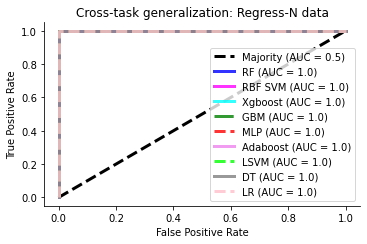

In [103]:
ml_models = ['random_forest',  'kernel_svm',  'xgboost', 'gbm', 'mlp', 'adaboost', 'linear_svm', 'decision_tree', 'logistic_regression',] 
#'knn', 
ml_model_names = {'random_forest': 'RF', 'adaboost': 'Adaboost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp': 'MLP'}
person_true_labels = regressN_testY.groupby('PID').first()
neutral = [0 for _ in range(len(person_true_labels))] # ROC for majority class prediction all the time 

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)
neutral_fpr, neutral_tpr, _ = roc_curve(person_true_labels, neutral) #roc curves

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

#RegressN Data 
axes.plot(neutral_fpr, neutral_tpr, linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    model_probs = predicted_probs_person_regressN[ml_model] # person-based prediction probabilities
    fpr, tpr, _ = roc_curve(person_true_labels, model_probs)
    axes.plot(fpr, tpr, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_AUC'][ml_model], 3))
                 +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('Cross-task generalization: Regress-N data')
plt.legend()
# axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//EDSSprediction//ROC_task_generalize_regressN_2NMFfeatures.png', dpi = 350)
plt.show()

## Subject generalization
#### Now, we need to first normalize between 0 and 1 and then fit and tranform using an NMF to get 2 features which we shuffle and then use the ones in training and ones in testing. Note that we cannot normalize or do NMF on training set and testing set separately because, the resultant vectors from train and test NMFs will have different directions (due to unequal variance). Due to this, we’ll end up comparing data registered on different axes. Therefore, the resulting vectors from train and test data should have same axes.
##### Refer https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/
#### Also, we cannot not combine the train and test set to obtain NMF components of whole data at once. Because, this would violate the entire assumption of generalization since test data would get 'leaked' into the training set. In other words, the test data set would no longer remain 'unseen'. Eventually, this will hammer down the generalization capability of the model.
### Hence, we derive the normalization parameters on the training set and then use the same parameters to normalize the test set. Similarly, for NMF, we fit the 2D NMF on training set and then tranform using the fitted NMF both the training and the test set. This way, neither we fit NMF on both training and test set separately nor do we mix them and then do NMF together.

In [138]:
def acc(y_true,y_pred):
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [139]:
def evaluate(model, test_features, yoriginal_, ypredicted_):
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 5
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []
    #For ROC curves 
    tpr_list = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold

        #Correctly classified strides i.e. 1 if stride is correctly classified and 0 if otherwise
        temp['correct'] = (temp['Label']==temp['pred'])

        #Proportion of correctly classified strides
        proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  

        proportion_strides_correct['True Label'] = temp[['PID', 'Label']].groupby('PID').first() 

        #Label for the person - 0=healthy, 1=MS patient
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
        (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
        (proportion_strides_correct['correct']<0.5) 

        #Probability of class 1 - MS patient for AUC calculation
        proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
        (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 

        fpr, tpr, _ = roc_curve(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tpr_list.append(tpr)

        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1']))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)

    return tpr_list, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [140]:
def drop_negatives(X):
#     global index_retained 
    X[X<0] = 0
    return X
#     newX = X[X>0].dropna()
#     index_retained = newX.index
#     newY = Y.loc[index_retained]
#     return newX, newY

In [142]:
#We do not use LDA/QDA since our features are not normally distributed 
def models(X, Y, model_name = 'random_forest'):
    '''
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name
    '''
    Y_ = Y['Label'] #Dropping the PID
    groups_ = Y['PID']
    gkf = GroupKFold(n_splits=5) 
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                RandomForestClassifier(random_state=0)) #FunctionTransformer(drop_negatives)
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15,0.1,0.05], \
        'gradientboostingclassifier__n_estimators':[50, 100, 150],\
        'gradientboostingclassifier__max_depth':[2,4,7],\
        'gradientboostingclassifier__min_samples_split':[2,4], \
        'gradientboostingclassifier__min_samples_leaf':[1,3],\
        'gradientboostingclassifier__max_features':['auto','sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                  LinearSVC(random_state=0))
        grid = {
            'linearsvc__loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'mlp'):
        mlp_grid = make_pipeline(MinMaxScaler(),  FunctionTransformer(drop_negatives),
                                decomposition.NMF(n_components=2, init='nndsvda', max_iter=500),
                                 MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0))
        grid = {
        'mlpclassifier__hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                                    , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
#     print (len(yoriginal), len(ypredicted))
    tpr_list, stride_person_metrics = evaluate(grid_search, Y, yoriginal, ypredicted)
    return tpr_list, stride_person_metrics

In [143]:
#CV for people generalize so no train-test split
X_regressN = regressN_df.drop(['Label', 'PID', 'TrialID', 'edss'], axis = 1)
Y_regressN = regressN_df[['PID', 'Label']] #PID to compute person based metrics later 

In [144]:
X_regressN.shape[0]*4/5

1157.6

In [146]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
# regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
# tprs_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models[1:]:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_regressN, Y_regressN, ml_model)
    regressN_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_regressN[ml_model] = tprs
    print ('********************************')

adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.9256919573338817, 0.8581619806603904, 0.8758547993032011, 0.865184550845726, 0.9687409334354935]
Stride-based model performance (standard deviation):  [0.034859731337386866, 0.07536834255686949, 0.098505749741479, 0.077684735026498, 0.022838859150136132]
Person-based model performance (mean):  [1.0, 1.0, 1.0, 1.0, 1.0]
Person-based model performance (standard deviation):  [0.0, 0.0, 0.0, 0.0, 0.0]
********************************
kernel_svm
best_params:  {'svc__gamma': 1}
Stride-based model performance (mean):  [0.9220663713263333, 0.9280768429633144, 0.7946839191606316, 0.8488035594216973, 0.9824830255037224]
Stride-based model performance (standard deviation):  [0.041693969795545814, 0.03792511691084906, 0.1517880471015139, 0.09141396760854377, 0.00972890347232857]
Person-based model performance (mean):  [0.95, 0.9, 1.0, 0.93333333333333

In [149]:
regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv(path+'..//EDSSprediction//subject_generalize_regressN_2NMFfeatures.csv')
tprs_regressN.to_csv(path+'..//EDSSprediction//subject_generalize_ROCresults_regressN_2NMFfeatures.csv')

In [150]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_mean_accuracy,0.929315,0.925692,0.922066,0.919118,0.922774,0.897588,0.857581,0.921320,0.853905,0.932481
stride_mean_precision,0.834094,0.858162,0.928077,0.838275,0.849441,0.840525,0.811906,0.916819,0.992649,0.833722
stride_mean_recall,0.920149,0.875855,0.794684,0.880179,0.876407,0.777176,0.704165,0.803753,0.476068,0.931450
stride_mean_F1,0.871948,0.865185,0.848804,0.855576,0.859500,0.798352,0.747492,0.850467,0.610532,0.877508
stride_mean_AUC,0.981087,0.968741,0.982483,0.975909,0.976129,0.960285,0.876476,0.982424,0.982756,0.967583
stride_std_accuracy,0.037777,0.034860,0.041694,0.030514,0.028493,0.045750,0.041962,0.040650,0.047784,0.040289
stride_std_precision,0.082205,0.075368,0.037925,0.088439,0.075058,0.090188,0.086820,0.038604,0.011745,0.094967
stride_std_recall,0.102855,0.098506,0.151788,0.094843,0.099861,0.173735,0.144102,0.143913,0.234839,0.084080
stride_std_F1,0.077650,0.077685,0.091414,0.074619,0.070244,0.114226,0.093596,0.088160,0.205513,0.078680
stride_std_AUC,0.007048,0.022839,0.009729,0.011551,0.011052,0.027552,0.074799,0.009728,0.009658,0.014996


In [ ]:
regressN_metrics = pd.read_csv(path+'..//EDSSprediction//subject_generalize_regressN_2NMFfeatures.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
tprs_regressN = pd.read_csv(path+'..//EDSSprediction//subject_generalize_ROCresults_regressN_2NMFfeatures.csv')
tprs_regressN.index = tprs_regressN['Unnamed: 0']
tprs_regressN.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
ml_models1 = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression']

for model in ml_models1:
    for idx in range(7):
#         print (model, idx)
        tprs_regressN[model][idx] = np.array(list(map(float, tprs_regressN[model][idx][1:-1].split())))


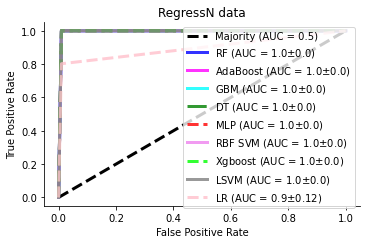

In [151]:
base_fpr = np.linspace(0, 1, 101)
ml_models = ['random_forest', 'adaboost', 'gbm', 'decision_tree', 'mlp', 'kernel_svm',  'xgboost', \
            'linear_svm', 'logistic_regression'] #'knn'
ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

#RegressN Data 
axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    tprs = tprs_regressN[ml_model] # person-based prediction probabilities
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
#     axes[2].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    axes.plot(base_fpr, mean_tprs, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_mean_AUC']
                     [ml_model], 2)) + r'$\pm$' + str(round(regressN_metrics.loc['person_std_AUC']
                     [ml_model], 2)) + ')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('RegressN data')
axes.legend() #loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//EDSSprediction//ROC_subject_generalize_regressN_2NMFfeatures.png', dpi = 350)
plt.show()